# Everytown for Gun Safety

## Research Technical Skills Test

In [1]:
# Import necessary libraries
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

### Read in the data and get a quick overview of what it includes

In [2]:
# Read in the data and get a preview of what it looks like
su_rates = pd.read_csv('SuicideRatesCompiledByKaggle.csv')
su_rates.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
"""
Remove commas from annual GDP variable and turn into numerical values
Rename columns for ease of use
"""
su_rates[' gdp_for_year ($) '] = su_rates[' gdp_for_year ($) '].str.replace(',','').astype(int)
su_rates.rename(columns={' gdp_for_year ($) ':'annual_gdp','gdp_per_capita ($)':'gdp_per_cap',\
                         'HDI for year':'HDI'}, inplace=True)

In [4]:
# Get the size of the data set
print("Number of rows in dataset: {}".format(su_rates.shape[0]))

Number of rows in dataset: 27820


In [5]:
# Quick overview of the minimum, maximum, mean, standard deviation, and other values for each variable
su_rates.describe()

,year,suicides_no,population,suicides/100k pop,HDI,annual_gdp,gdp_per_cap
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,2.782000e+04,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,4.455810e+11,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,1.453610e+12,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,4.691962e+07,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,8.985353e+09,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,4.811469e+10,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,2.602024e+11,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,1.812071e+13,126352.000000


In [6]:
# Number of countries in the dataset
su_rates.country.nunique()

101

## Exploratory analysis

In [7]:
# Reestablish multiplier for normalizing suicide rates by population
rate_mult = 100000

In [8]:
# Get overall stats for suicide around the world
year_group = su_rates.groupby(['year']).sum()
year_group.reset_index(inplace=True)
year_group.drop(columns=['suicides/100k pop','HDI','annual_gdp','gdp_per_cap'], inplace=True)
year_group['suicides_pop_norm'] = year_group['suicides_no']/year_group['population']*rate_mult
year_group.head()

,year,suicides_no,population,suicides_pop_norm
0,1985,116063,1008600086,11.507336
1,1986,120670,1029909613,11.716562
2,1987,126842,1095029726,11.583430
3,1988,121026,1054094424,11.481514
4,1989,160244,1225514347,13.075653


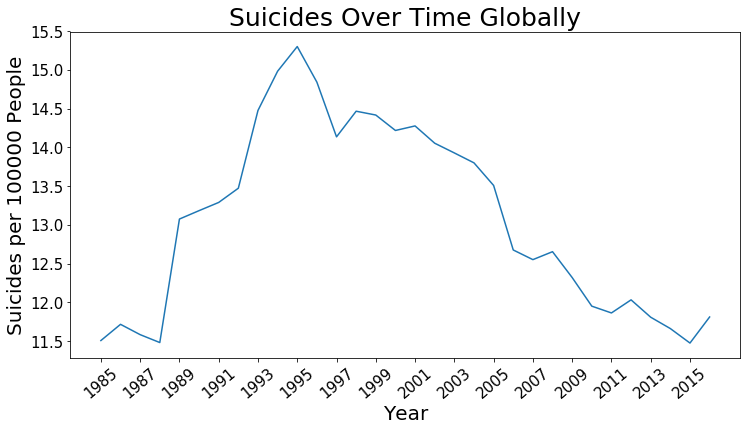

In [9]:
# Plot suicides globally over time
plt.figure(figsize=(12,6))
plt.plot(year_group['year'], year_group['suicides_pop_norm'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Suicides per {} People'.format(rate_mult), fontsize=20)
plt.xticks(np.arange(year_group.year.min(),year_group.year.max(),step=2), rotation=40, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Suicides Over Time Globally', fontsize=25)
plt.show()

In [10]:
# Group the data by country and year for further analysis
country_groups = su_rates.groupby(['country', 'year', 'annual_gdp', 'gdp_per_cap']).sum()
country_groups.reset_index(inplace=True)
country_groups.drop(columns=['suicides/100k pop', 'HDI'], inplace=True)
# Recreate suicides/100k pop since groupby sum resulted in inaccurate totals for this variable
country_groups['suicides_pop_norm'] = country_groups['suicides_no']/country_groups['population']*rate_mult
country_groups.head()

,country,year,annual_gdp,gdp_per_cap,suicides_no,population,suicides_pop_norm
0,Albania,1987,2156624900,796,73,2709600,2.694125
1,Albania,1988,2126000000,769,63,2764300,2.279058
2,Albania,1989,2335124988,833,68,2803100,2.425886
3,Albania,1992,709452584,251,47,2822500,1.665190
4,Albania,1993,1228071038,437,73,2807300,2.600363


In [11]:
# Get global annual GDP
annual_gdp = country_groups.groupby('year').sum().reset_index()
annual_gdp.drop(columns=['gdp_per_cap'], inplace=True)
annual_gdp['gdp_per_cap'] = annual_gdp['annual_gdp']/annual_gdp['population']
annual_gdp.head()

,year,annual_gdp,suicides_no,population,suicides_pop_norm,gdp_per_cap
0,1985,9247062852875,116063,1008600086,460.530610,9168.215412
1,1986,11050802665239,120670,1029909613,456.441340,10729.876220
2,1987,12980823522850,126842,1095029726,531.825661,11854.311545
3,1988,14629807600373,121026,1054094424,529.617190,13879.029494
4,1989,15968188470598,160244,1225514347,571.042605,13029.785012


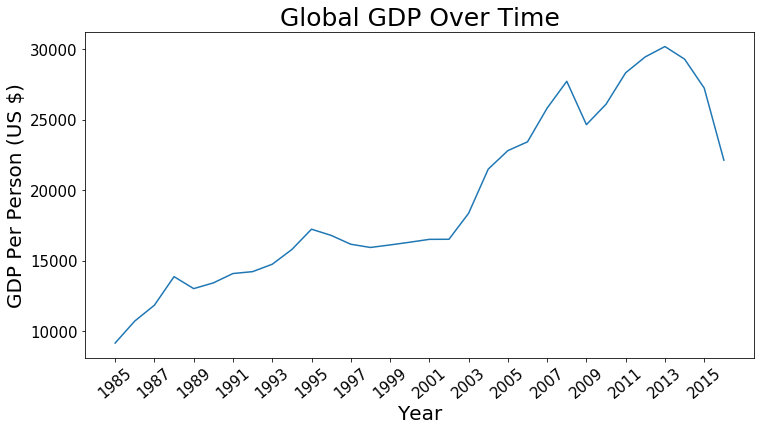

In [12]:
# Plot of global annual GDP per person
plt.figure(figsize=(12,6))
plt.plot(annual_gdp['year'], annual_gdp['gdp_per_cap'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('GDP Per Person (US $)', fontsize=20)
plt.xticks(np.arange(country_groups.year.min(),country_groups.year.max(),step=2), rotation=40, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Global GDP Over Time', fontsize=25)
plt.show()

In [13]:
# Country and year with the most suicides out of all nations
country_groups[country_groups.suicides_no==country_groups.suicides_no.max()]

,country,year,annual_gdp,gdp_per_cap,suicides_no,population,suicides_pop_norm
1752,Russian Federation,1994,395077301248,2853,61420,138476200,44.354192


In [14]:
# Get a list of countries in the data set for the following plot
countries = country_groups['country'].unique()
countries

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

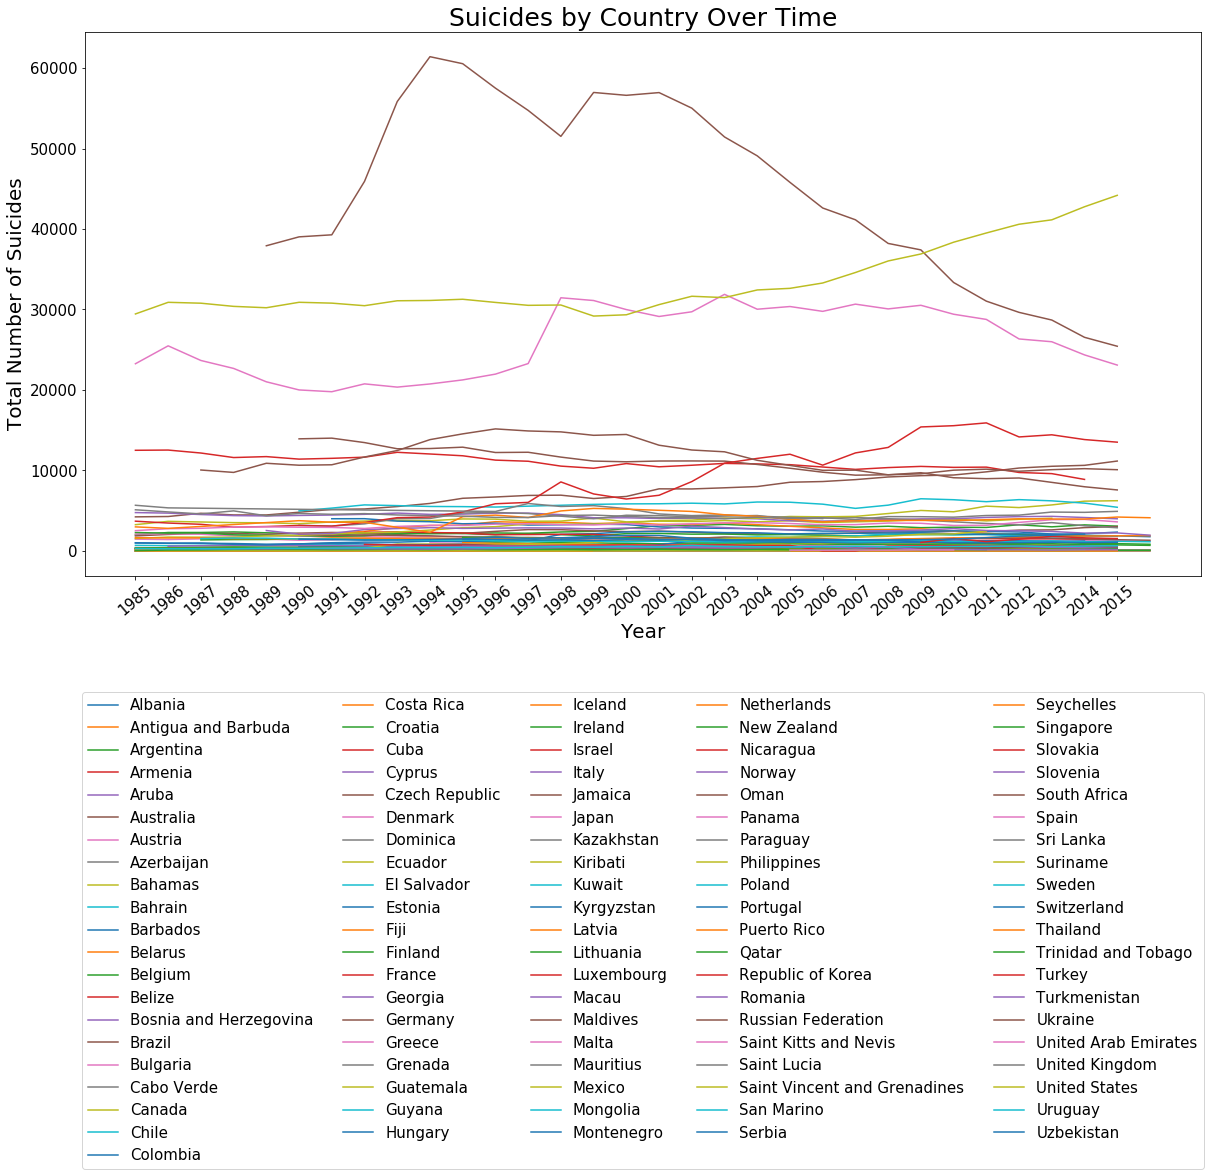

In [15]:
# Plot suicides per country over time
plt.figure(figsize=(20,10))
for i in range(len(countries)):
    years = country_groups[country_groups['country']==countries[i]]['year']
    sui_no = country_groups[country_groups['country']==countries[i]]['suicides_no']
    plt.plot(years, sui_no, label=countries[i])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Total Number of Suicides', fontsize=20)
plt.xticks(np.arange(country_groups.year.min(),country_groups.year.max(),step=1), rotation=40, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Suicides by Country Over Time', fontsize=25)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=5,fontsize=15)
plt.show()

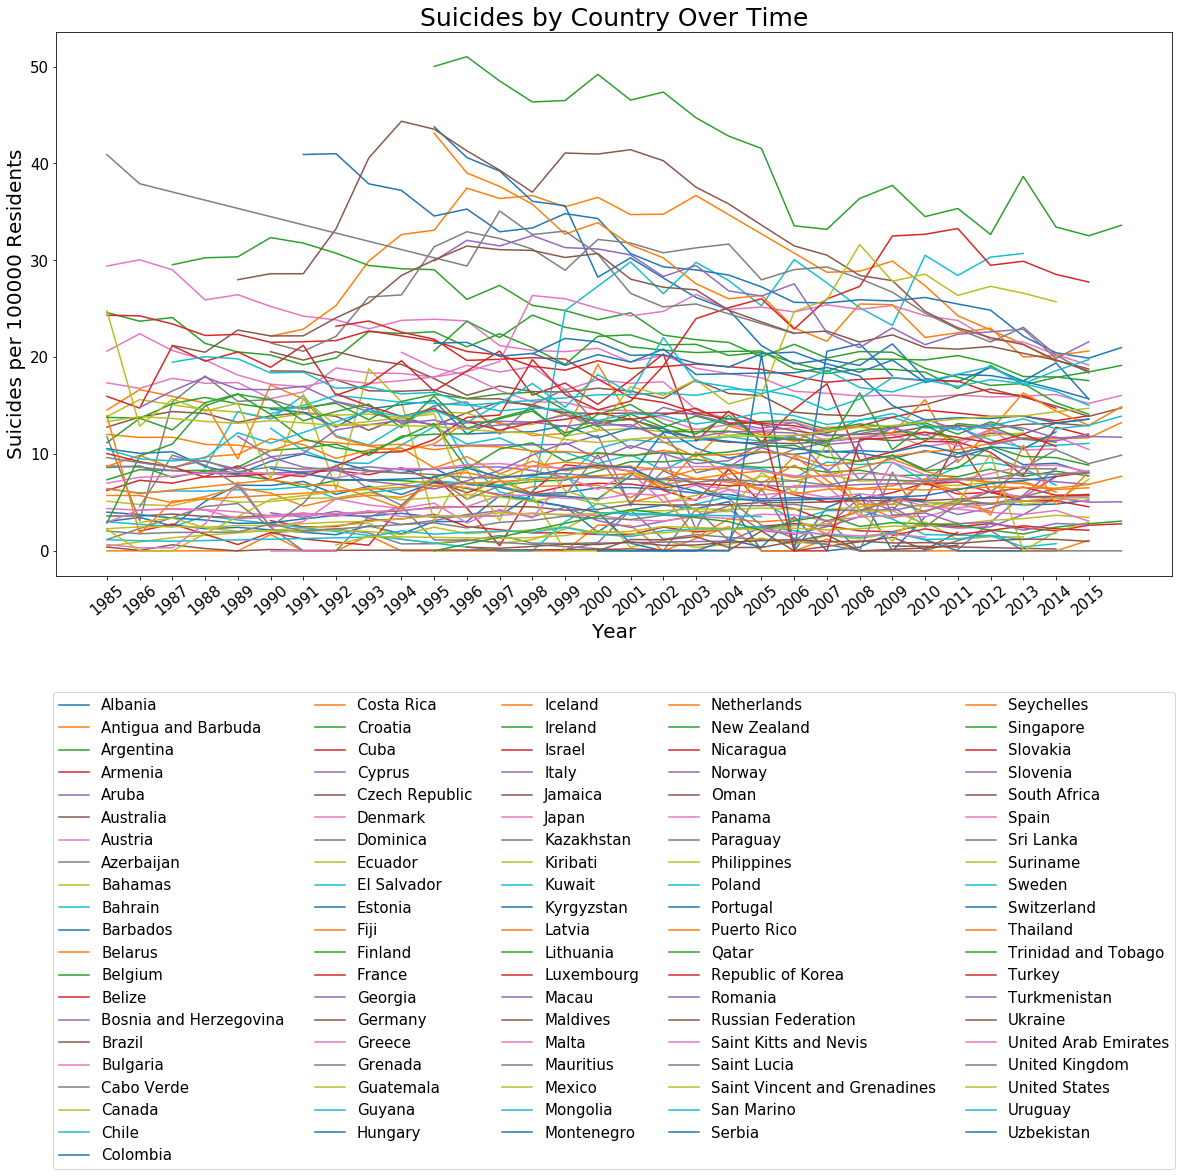

In [16]:
# Similar plot but normalized by population
plt.figure(figsize=(20,10))
for i in range(len(countries)):
    years = country_groups[country_groups['country']==countries[i]]['year']
    sui_no = country_groups[country_groups['country']==countries[i]]['suicides_pop_norm']
    plt.plot(years, sui_no, label=countries[i])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Suicides per {} Residents'.format(rate_mult), fontsize=20)
plt.xticks(np.arange(country_groups.year.min(),country_groups.year.max(),step=1), rotation=40, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Suicides by Country Over Time', fontsize=25)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=5,fontsize=15)
plt.show()

### Note:

The plot of total suicides per country over time reveals the presence of at least a few outliers in absolute terms while the second plot shows that many countries have suicide rates that are much more comparable to each other once those rates are normalized by population.

Both of the above plots, however, have too much information to be easily interpretable. I therefore decided to filter down to those countries with particularly high suicide rates (normalized by population).

## Revised analysis

In [17]:
"""
Get all countries that, at any point, had a normalized suicide rate within 2 standard deviations of the 
maximum for the entire grouped dataset
"""
high_countries = country_groups[country_groups['suicides_pop_norm']>country_groups['suicides_pop_norm'].max() - \
                                country_groups['suicides_pop_norm'].std()*2]['country'].unique()
high_countries

array(['Belarus', 'Estonia', 'Hungary', 'Latvia', 'Lithuania',
       'Republic of Korea', 'Russian Federation', 'Sri Lanka'],
      dtype=object)

In [18]:
# Create a new dataframe that only includes those countries located in the previous test with high suicide rates
high_df = country_groups[country_groups['country'].isin(high_countries)]
high_df.head()

,country,year,annual_gdp,gdp_per_cap,suicides_no,population,suicides_pop_norm
266,Belarus,1990,21650000000,2301,2085,9408800,22.160105
267,Belarus,1991,18000000000,1899,2169,9476200,22.888922
268,Belarus,1992,17037037037,1780,2424,9570900,25.326772
269,Belarus,1993,16280991736,1689,2885,9641100,29.923971
270,Belarus,1994,14932024169,1547,3153,9653900,32.660376


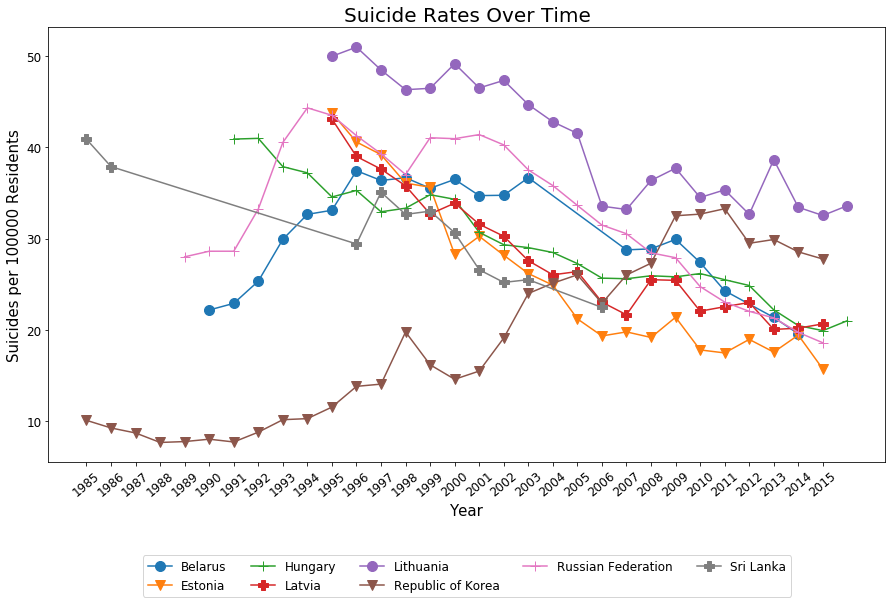

In [19]:
# Similar plot but normalized by population
plt.figure(figsize=(15, 8))
marker = itertools.cycle(('o', 'v', '+', 'P')) 
for i in range(len(high_countries)):
    years = high_df[high_df['country']==high_countries[i]]['year']
    sui_no = high_df[high_df['country']==high_countries[i]]['suicides_pop_norm']
    plt.plot(years, sui_no, marker = next(marker), label=high_countries[i], markersize=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Suicides per {} Residents'.format(rate_mult), fontsize=15)
plt.xticks(np.arange(country_groups.year.min(),country_groups.year.max(),step=1), rotation=40, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Suicide Rates Over Time', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=5,fontsize=12)
plt.show()

### Note:

This plot is much more interpretable. We can see that Lithuania has consistently remained at the top in terms of suicide rates per person in that country. We can also see that Russia, although it had the highest number of suicides per person in 1994 for the entire data set (which is even more striking given its comparatively large population), has seen a steady decline in suicide rates.

Two of the more notable findings from this plot include the significant increas in suicides in South Korea as well as the lack of data for Sri Lanka after 2006.

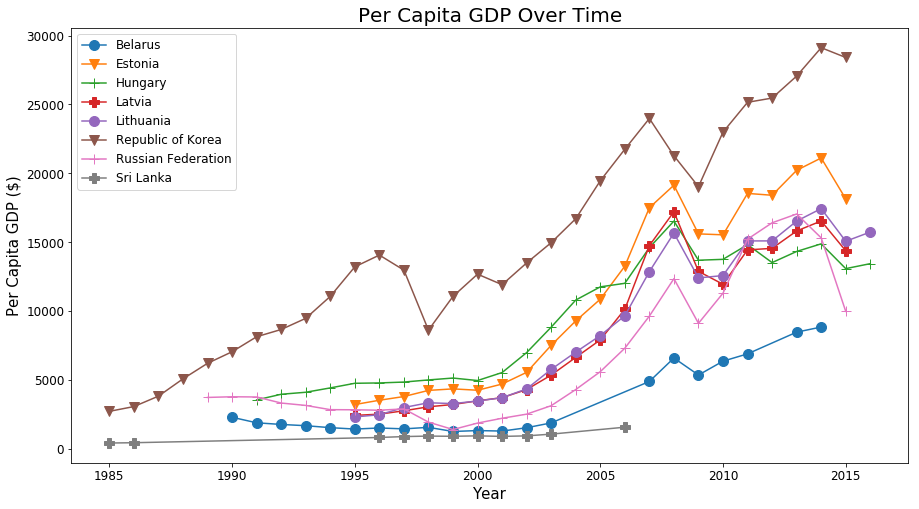

In [20]:
# Plotting suicide rates by per capita GDP
plt.figure(figsize=(15, 8))
marker = itertools.cycle(('o', 'v', '+', 'P')) 
for i in range(len(high_countries)):
    years = high_df[high_df['country']==high_countries[i]]['year']
    gdp = high_df[high_df['country']==high_countries[i]]['gdp_per_cap']
    plt.plot(years, gdp, marker = next(marker), label=high_countries[i], markersize=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Per Capita GDP ($)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Per Capita GDP Over Time', fontsize=20)
plt.legend(loc='upper left',fontsize=12)
plt.show()

### Note:

What is especially notable about this plot is that South Korea's per capita GDP has continually risen over the same period of time that it's suicide rate also has. This is in contrast to the other coutries with particularly high suicide rates, which have all seen similar gains in per capita GDP but also have mostly declining suicide rates. Clearly, in South Korea, greater economic wealth for individuals has not translated perfectly into improved mental health.

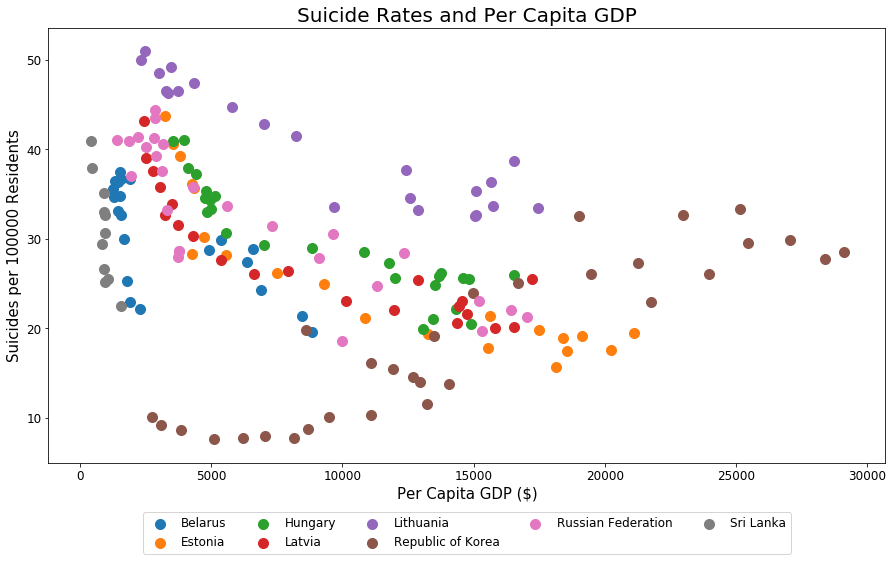

In [21]:
# Plotting suicide rates by per capita GDP
plt.figure(figsize=(15, 8))
marker = itertools.cycle(('o', 'v', '+', 'P')) 
for i in range(len(high_countries)):
    gdp = high_df[high_df['country']==high_countries[i]]['gdp_per_cap']
    sui_no = high_df[high_df['country']==high_countries[i]]['suicides_pop_norm']
    plt.scatter(gdp, sui_no, label=high_countries[i], s=100)
plt.xlabel('Per Capita GDP ($)', fontsize=15)
plt.ylabel('Suicides per {} Residents'.format(rate_mult), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Suicide Rates and Per Capita GDP', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=5,fontsize=12)
plt.show()

### Note:

The above plot shows suicide rates and per capita GDP for each of the countries previously found to have particularly high suicide rates. Note that there are multiple points plotted for each country since each country has multiple years of data. Future analyses could include alternative methods for plotting the data - for example, by taking the mean GDP and suicide rate for each country over time or by taking the GDP and suicide rate from the latest year or years.

In [22]:
# Create variables that will be fed into linear regression model
y = high_df['suicides_pop_norm'].tolist()
X = high_df['gdp_per_cap'].tolist()
newx = sm.add_constant(X)

In [23]:
# Create linear regression
ols_fit = smf.OLS(y, newx).fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     36.14
Date:                Mon, 20 May 2019   Prob (F-statistic):           1.02e-08
Time:                        19:41:06   Log-Likelihood:                -644.98
No. Observations:                 180   AIC:                             1294.
Df Residuals:                     178   BIC:                             1300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.2335      1.081     31.670      0.000      32.100      36.367
x1            -0.0006   9.75e-05     -6.012      0.000      -0.001      -0.000
==============================================================================
Omnibus:                        8.159   Durbin-Watson:                   0.296
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                7.947
Skew:                          -0.475   Prob(JB):                       0.0188
Kurtosis:                       3.398   Cond. No.                     1.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Note:

Our linear regression model has some shortcomings, notably that it only produces an R squared value of .169, suggesting that other data would need to be incorporated into the model to fully explain suicide rates. This makes intuitive sense - we wouldn't assume that per capita GDP is the only important explanatory information necessary for understanding suicide rates in a given country. Cultural factors, political stability, gun ownership laws, and many other variables contribute to suicide rates. Still, this gives us a place to start.

In [24]:
# Get the slope and intercept of the linear regression model for the following plot
slope, intercept = ols_fit.params[1], ols_fit.params[0]
newy = (high_df['gdp_per_cap']*slope + intercept).tolist()

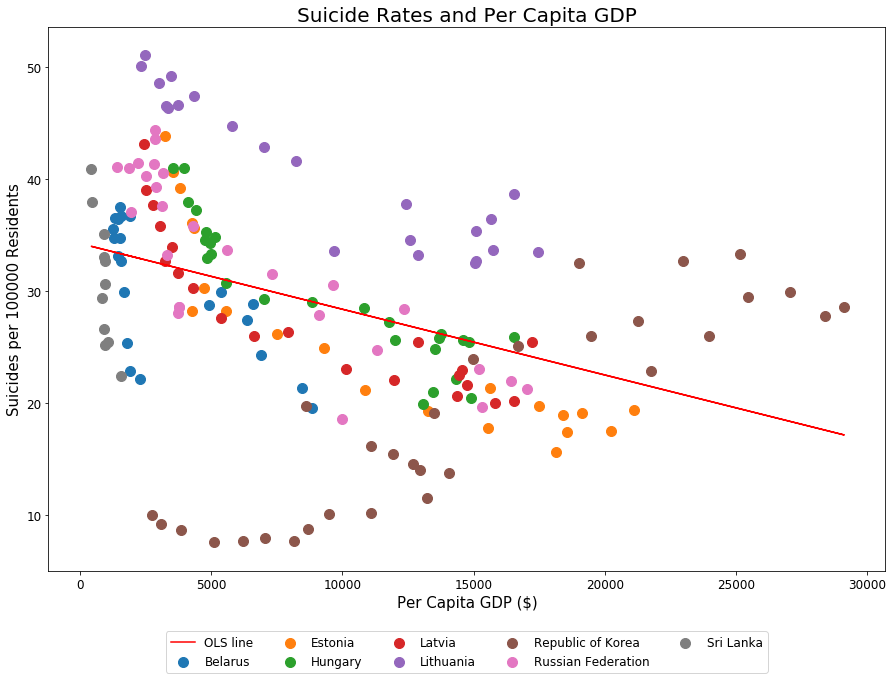

In [25]:
# Another plot of suicide rates and per capita GDP but with linear regression model included
plt.figure(figsize=(15, 10))
marker = itertools.cycle(('o', 'v', '+', 'P')) 
for i in range(len(high_countries)):
    gdp = high_df[high_df['country']==high_countries[i]]['gdp_per_cap']
    sui_no = high_df[high_df['country']==high_countries[i]]['suicides_pop_norm']
    plt.scatter(gdp, sui_no, label=high_countries[i], s=100)
plt.plot(high_df['gdp_per_cap'], newy, color='red', label='OLS line')
plt.xlabel('Per Capita GDP ($)', fontsize=15)
plt.ylabel('Suicides per {} Residents'.format(rate_mult), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Suicide Rates and Per Capita GDP', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=5,fontsize=12)
plt.show()

## Human Development Index (HDI)

We can use HDI as another way to understand suicide rates by country rather than only looking at GDP. HDI tries to assess the development and growth of nations by looking at quality of life factors for each country's citizens.

It should be noted that many rows in the data set are missing HDI values:

In [26]:
print("Number of rows in data set missing HDI values: {} out of {} total rows"\
      .format(su_rates[su_rates['HDI'].isnull()].shape[0], su_rates.shape[0]))
print("Number of rows in data set missing GDP values: {}".format(su_rates[su_rates['annual_gdp']\
                                                                          .isnull()].shape[0]))

Number of rows in data set missing HDI values: 19456 out of 27820 total rows
Number of rows in data set missing GDP values: 0


In [27]:
# Create a new dataframe for HDI analysis with no missing values
hdi = su_rates[su_rates.HDI.notnull()]
hdi.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI,annual_gdp,gdp_per_cap,generation
72,Albania,1995,male,25-34 years,13,232900,5.58,Albania1995,0.619,2424499009,835,Generation X
73,Albania,1995,male,55-74 years,9,178000,5.06,Albania1995,0.619,2424499009,835,Silent
74,Albania,1995,female,75+ years,2,40800,4.90,Albania1995,0.619,2424499009,835,G.I. Generation
75,Albania,1995,female,15-24 years,13,283500,4.59,Albania1995,0.619,2424499009,835,Generation X
76,Albania,1995,male,15-24 years,11,241200,4.56,Albania1995,0.619,2424499009,835,Generation X


In [28]:
# Group the data by country and year to get summary stats on the number of suicides each year and total population
hdi_grouped = hdi.groupby(['country', 'year', 'HDI']).sum()
hdi_grouped.reset_index(inplace=True)
hdi_grouped.drop(columns=['suicides/100k pop','annual_gdp','gdp_per_cap'], inplace=True)
# Recreate suicides/100k pop since groupby sum resulted in inaccurate totals for this variable
hdi_grouped['suicides_pop_norm'] = hdi_grouped['suicides_no']/hdi_grouped['population']*rate_mult
hdi_grouped.head()

,country,year,HDI,suicides_no,population,suicides_pop_norm
0,Albania,1995,0.619,88,2903400,3.030929
1,Albania,2000,0.656,54,2796300,1.931123
2,Albania,2005,0.695,0,2783320,0.000000
3,Albania,2010,0.722,96,2736025,3.508740
4,Antigua and Barbuda,2012,0.781,0,88703,0.000000


In [29]:
# Get list of countries in HDI dataframe for plotting analysis
hdi_countries = hdi_grouped.country.unique()
hdi_countries

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus',
       'Czech Republic', 'Denmark', 'Ecuador', 'El Salvador', 'Estonia',
       'Fiji', 'Finland', 'France', 'Georgia', 'Germany', 'Greece',
       'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'Iceland', 'Ireland',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan', 'Kuwait',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Maldives',
       'Malta', 'Mauritius', 'Mexico', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania',
       'Saint Lucia', 'Saint Vincent and Grenadines', 'Serbia',
       'Seychelles', 'Singapore', 'Slovakia', 'Slovenia

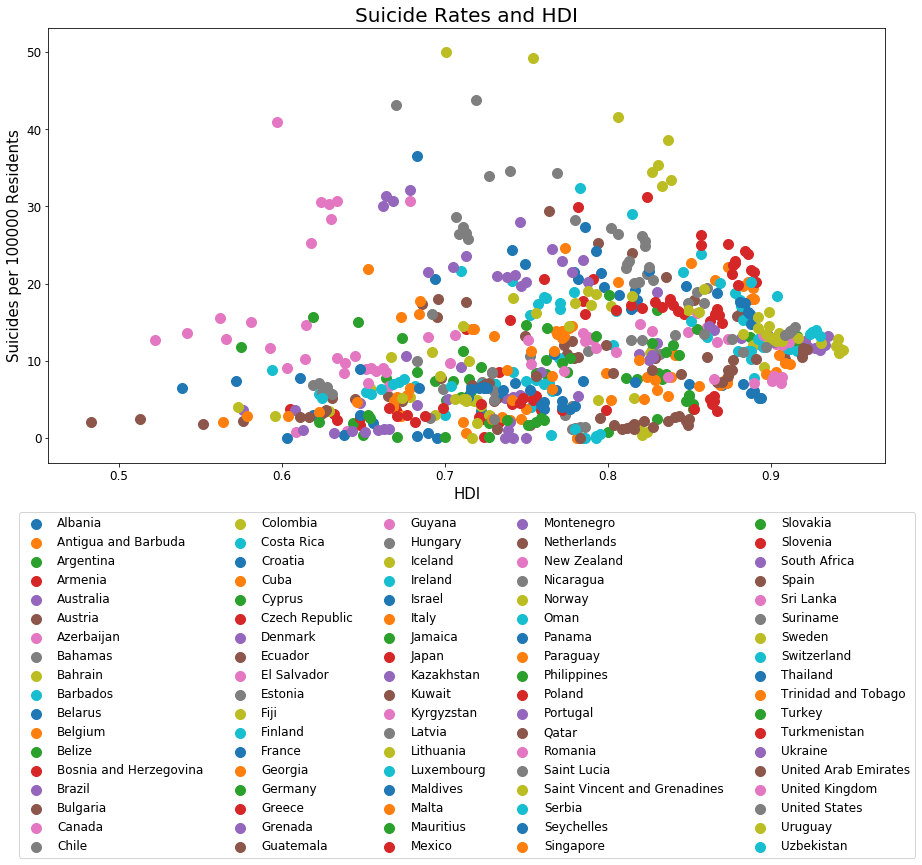

In [30]:
# Plotting suicide rates by HDI with all countries
plt.figure(figsize=(15, 8))
for i in range(len(hdi_countries)):
    hdi = hdi_grouped[hdi_grouped['country']==hdi_countries[i]]['HDI']
    sui_no = hdi_grouped[hdi_grouped['country']==hdi_countries[i]]['suicides_pop_norm']
    plt.scatter(hdi, sui_no, label=hdi_countries[i], s=100)
plt.xlabel('HDI', fontsize=15)
plt.ylabel('Suicides per {} Residents'.format(rate_mult), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Suicide Rates and HDI', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=5,fontsize=12)
plt.show()

### Note:

Again, we have a plot that is not easily interpretable. So let's just look at the countries with high rates.

In [31]:
"""
Get all countries that, at any point, had a normalized suicide rate within 2 standard deviations of the 
maximum for the entire grouped dataset
"""
high_hdi = hdi_grouped[hdi_grouped['suicides_pop_norm']>hdi_grouped['suicides_pop_norm'].max() - \
                                hdi_grouped['suicides_pop_norm'].std()*2]['country'].unique()
high_hdi

array(['Belarus', 'Estonia', 'Hungary', 'Latvia', 'Lithuania',
       'Sri Lanka'], dtype=object)

In [32]:
# Create a new dataframe that only includes those countries located in the previous test with high suicide rates
high_hdi_df = hdi_grouped[hdi_grouped['country'].isin(high_hdi)]
high_hdi_df.head()

,country,year,HDI,suicides_no,population,suicides_pop_norm
68,Belarus,2000,0.683,3483,9543479,36.496125
69,Belarus,2010,0.786,2459,8981193,27.379436
70,Belarus,2011,0.793,2172,8947320,24.275425
71,Belarus,2013,0.796,1902,8910240,21.346226
72,Belarus,2014,0.798,1741,8906977,19.546475


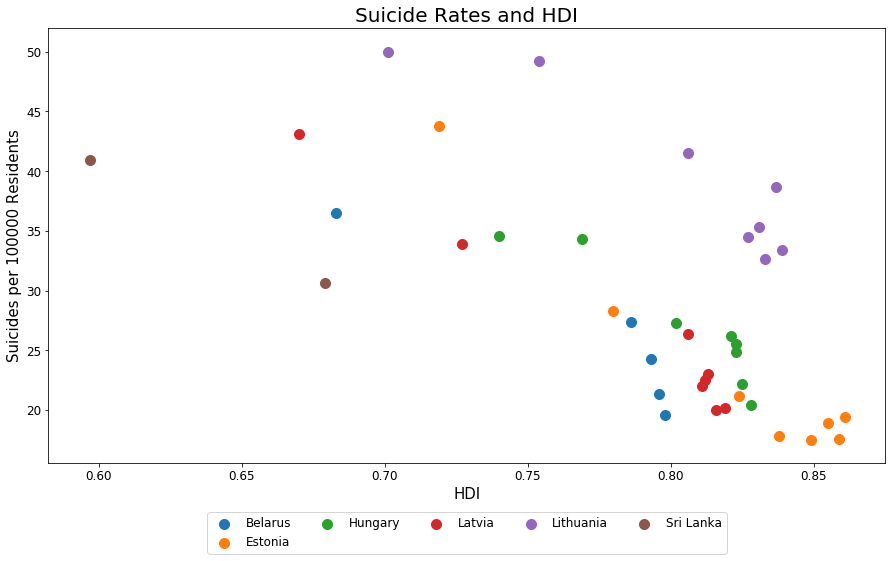

In [33]:
# Plotting suicide rates by HDI for only the countries with the highest suicide rates
plt.figure(figsize=(15, 8))
for i in range(len(high_hdi)):
    hdi = high_hdi_df[high_hdi_df['country']==high_hdi[i]]['HDI']
    sui_no = high_hdi_df[high_hdi_df['country']==high_hdi[i]]['suicides_pop_norm']
    plt.scatter(hdi, sui_no, label=high_hdi[i], s=100)
plt.xlabel('HDI', fontsize=15)
plt.ylabel('Suicides per {} Residents'.format(rate_mult), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Suicide Rates and HDI', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=5,fontsize=12)
plt.show()

In [34]:
# Create variables that will be fed into linear regression model
hdi_y = high_hdi_df['suicides_pop_norm'].tolist()
hdi_X = high_hdi_df['HDI'].tolist()
hdi_newx = sm.add_constant(hdi_X)

In [35]:
# Create linear regression
ols_hdi = smf.OLS(hdi_y, hdi_newx).fit()
ols_hdi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     26.37
Date:                Mon, 20 May 2019   Prob (F-statistic):           9.28e-06
Time:                        19:41:10   Log-Likelihood:                -130.64
No. Observations:                  39   AIC:                             265.3
Df Residuals:                      37   BIC:                             268.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.6749     15.190      7.023      0.000      75.897     137.453
x1           -98.3348     19.149     -5.135      0.000    -137.135     -59.535
==============================================================================
Omnibus:                        6.059   Durbin-Watson:                   0.678
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                5.872
Skew:                           0.942   Prob(JB):                       0.0531
Kurtosis:                       2.749   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Note:

Interestingly, the linear regression model that relies on HDI to explain suicide rates as opposed to GDP is much more successful in explaining the data. The R squared value of .416 shows that this single variable is a relatively good proxy for estimating the suicide rate for a given country. This makes some intuitive sense because HDI incorporates multiple metrics, including health, education, and standard of living measures. A lot more information is therefore bundled together in a single HDI score than in the raw GDP per capita.

In [36]:
# Get the slope and intercept of the linear regression model for the following plot
hdi_slope, hdi_intercept = ols_hdi.params[1], ols_hdi.params[0]
hdi_newy = (high_hdi_df['HDI']*hdi_slope + hdi_intercept).tolist()

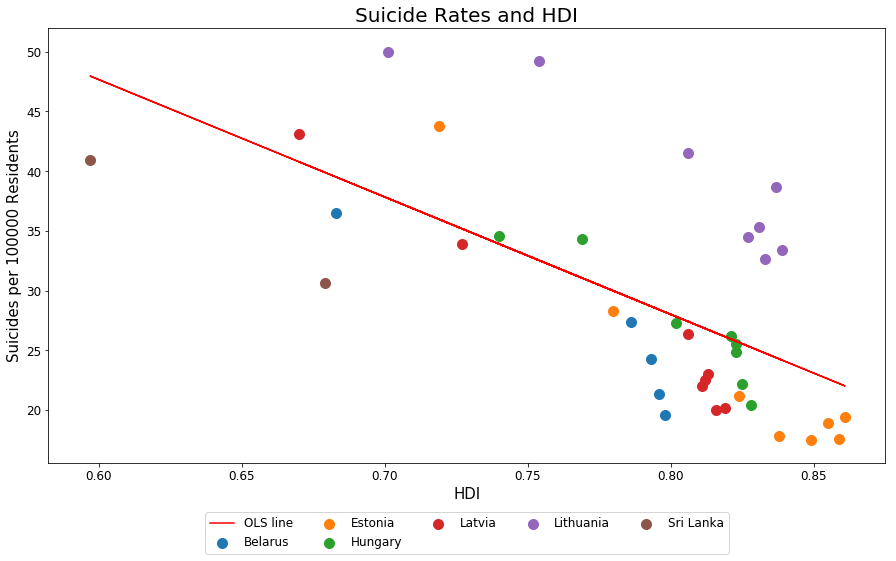

In [37]:
# Plotting suicide rates by HDI for only the countries with the highest suicide rates
plt.figure(figsize=(15, 8))
for i in range(len(high_hdi)):
    hdi = high_hdi_df[high_hdi_df['country']==high_hdi[i]]['HDI']
    sui_no = high_hdi_df[high_hdi_df['country']==high_hdi[i]]['suicides_pop_norm']
    plt.scatter(hdi, sui_no, label=high_hdi[i], s=100)
plt.plot(high_hdi_df['HDI'], hdi_newy, color='red', label='OLS line')
plt.xlabel('HDI', fontsize=15)
plt.ylabel('Suicides per {} Residents'.format(rate_mult), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Suicide Rates and HDI', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=5,fontsize=12)
plt.show()

## Final Analyses: Gender and Age

In [38]:
# Create a new dataframe grouped by gender and year
gender = su_rates.groupby(['sex','year']).sum()
gender.reset_index(inplace=True)
gender = gender[['sex','year','suicides_no','population']]
gender['suicides_pop_norm'] = gender['suicides_no']/gender['population']*rate_mult
gender.head()

,sex,year,suicides_no,population,suicides_pop_norm
0,female,1985,32479,513013055,6.331028
1,female,1986,33852,524465866,6.454567
2,female,1987,35006,559183789,6.260196
3,female,1988,33015,538779773,6.127736
4,female,1989,41361,629626203,6.569136


In [39]:
# Create sub dataframes for females and males to make plotting simpler
female = gender[gender['sex']=='female']
female.reset_index(drop=True, inplace=True)
male = gender[gender['sex']=='male']
male.reset_index(drop=True, inplace=True)

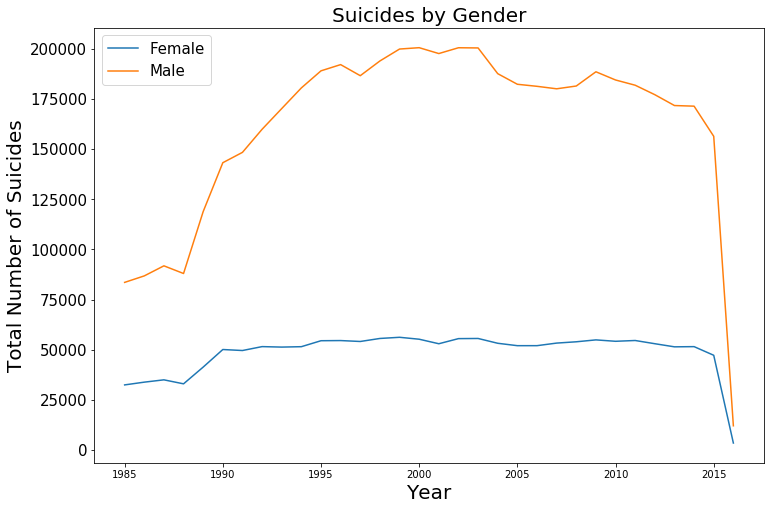

In [40]:
# Plot suicides by gender over time
plt.figure(figsize=(12,8))
plt.plot(female.year, female.suicides_no, label='Female')
plt.plot(male.year, male.suicides_no, label='Male')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Total Number of Suicides', fontsize=20)
plt.yticks(fontsize=15)
plt.title('Suicides by Gender', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.show()

### Note:

The above plot is misleading toward the end where we see a sharp drop in the number of suicides for each gender. This is obviously due to an aberration in the data in which the suicide figures were not collected for all countries (the total population of females and males drops significantly in 2016 in the dataset).

To correct for this, we can look to the following plot normalized by population:

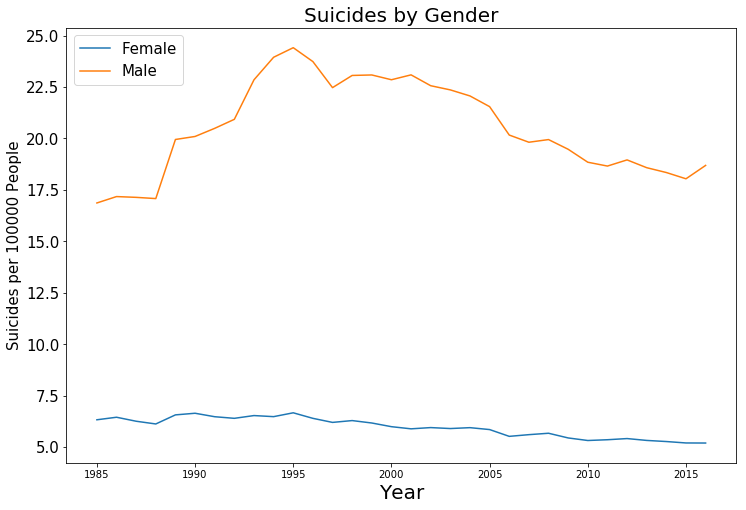

In [41]:
# Plot suicides by gender normalized by population of each gender
plt.figure(figsize=(12,8))
plt.plot(female.year, female.suicides_pop_norm, label='Female')
plt.plot(male.year, male.suicides_pop_norm, label='Male')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Suicides per {} People'.format(rate_mult), fontsize=15)
plt.yticks(fontsize=15)
plt.title('Suicides by Gender', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.show()

### Note:

We can see that males have a much higher suicide rate than females. This is a significant finding that merits further investigation and research.

In [42]:
# Finally, create a separate dataframe for age groups
age = su_rates.groupby(['age','year']).sum()
age.reset_index(inplace=True)
age = age[['age','year','suicides_no','population']]
age['suicides_pop_norm'] = age['suicides_no']/age['population']*rate_mult
age.head()

,age,year,suicides_no,population,suicides_pop_norm
0,15-24 years,1985,17870,196974439,9.072243
1,15-24 years,1986,18063,199238573,9.066016
2,15-24 years,1987,16432,208588197,7.877723
3,15-24 years,1988,15337,196035518,7.823582
4,15-24 years,1989,18636,219927016,8.473720


In [43]:
# Get each unique age category for the following plot
age_cats = age.age.unique()
age_cats

array(['15-24 years', '25-34 years', '35-54 years', '5-14 years',
       '55-74 years', '75+ years'], dtype=object)

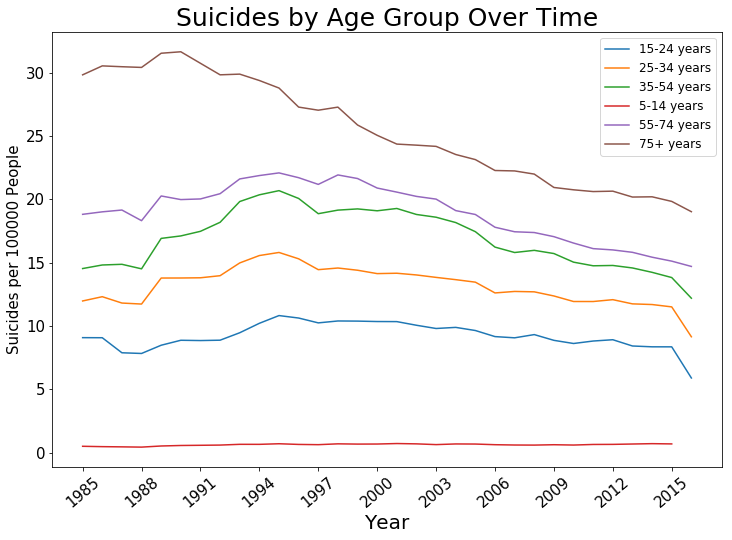

In [44]:
# Plot suicides by age group over time
plt.figure(figsize=(12,8))
for i in range(len(age_cats)):
    years = age[age['age']==age_cats[i]]['year']
    sui_no = age[age['age']==age_cats[i]]['suicides_pop_norm']
    plt.plot(years, sui_no, label=age_cats[i])
plt.xlabel('Year', fontsize=20)
plt.ylabel('Suicides per {} People'.format(rate_mult), fontsize=15)
plt.xticks(np.arange(age.year.min(),age.year.max(),step=3), rotation=40, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Suicides by Age Group Over Time', fontsize=25)
plt.legend(fontsize=12)
plt.show()

### Note:

We can see that for most age groups, suicide rates peaked in the mid to late 1990s (except for indidivuals 75 and older) and have mostly steadily declined since then. There is a clear progression where older age groups tend to have higher suicide rates.